## Loading Packages

In [12]:
import os
import sys
import h5py
import glob
import json
import math
import time
import timeit
import hdbscan
import itertools
import importlib
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from scipy import stats
import keras.backend as K
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import DBSCAN, KMeans
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, spearmanr
from sklearn.preprocessing import normalize, scale, MinMaxScaler, StandardScaler
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram, linkage, fcluster

from tcn import TCN
from pandas import read_csv
from sklearn.svm import SVC
from sklearn import svm, datasets
from IPython.display import Image
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.metrics import Precision, Recall
from sktime.transformations.panel.rocket import Rocket
from sklearn.metrics.cluster import normalized_mutual_info_score
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense, add, Dropout, concatenate, LSTM
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss, classification_report, silhouette_score

In [2]:
df = pd.read_csv('')

df = df.drop(df.columns[0], axis=1)
data = df.iloc[:, :-2]
data = data.iloc[:-1, :]
data.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,318,319,320,321,322,323,324,325,326,327
2470,0,2048,510,511,1,15182,75,0,241,14,...,49,148,593,164,1,82,256,14,0,241
2471,0,2049,510,511,1,15182,75,0,252,3,...,49,148,593,164,1,82,256,2,0,253
2472,0,2048,510,511,1,15185,75,0,247,8,...,49,148,593,164,1,82,256,8,0,247
2473,0,2049,510,511,1,15185,75,0,242,13,...,49,148,593,164,1,82,256,13,0,242
2474,0,2049,510,511,1,15185,75,0,253,2,...,51,148,593,164,1,82,256,2,0,253
2475,0,2048,510,511,1,15182,75,0,248,7,...,50,148,593,164,1,82,256,7,0,248
2476,0,2050,510,511,1,15188,75,0,243,12,...,51,148,593,164,1,82,256,12,0,243
2477,0,2048,510,511,1,15185,75,0,254,1,...,50,148,593,164,1,82,256,1,0,254
2478,0,2048,510,511,1,15185,75,0,249,6,...,51,148,593,164,1,82,256,6,0,249
2479,0,2048,510,511,1,15185,75,0,244,11,...,50,148,593,164,1,82,256,11,0,244


In [3]:
df_all = df.iloc[:-1, :]  
predictor_columns = df_all.iloc[:, :-2]
X_full = predictor_columns.values   # Features
y_full = df['Fault_Status'].values  # Labels

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X_full = scaler.fit_transform(X_full)

## Splitting Techniques

In [4]:
# plotting parameters
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)      # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=17)             # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)   # fontsize of the figure title

Split 1:
  Training set class distribution: {0: 28, 1: 221}
  Testing set class distribution: {0: 159, 1: 90}
--------------------------------------------------
Split 2:
  Training set class distribution: {0: 187, 1: 311}
  Testing set class distribution: {0: 243, 1: 6}
--------------------------------------------------
Split 3:
  Training set class distribution: {0: 430, 1: 317}
  Testing set class distribution: {0: 105, 1: 144}
--------------------------------------------------
Split 4:
  Training set class distribution: {0: 535, 1: 461}
  Testing set class distribution: {0: 85, 1: 164}
--------------------------------------------------
Split 5:
  Training set class distribution: {0: 620, 1: 625}
  Testing set class distribution: {0: 170, 1: 79}
--------------------------------------------------
Split 6:
  Training set class distribution: {0: 790, 1: 704}
  Testing set class distribution: {0: 31, 1: 218}
--------------------------------------------------
Split 7:
  Training set class

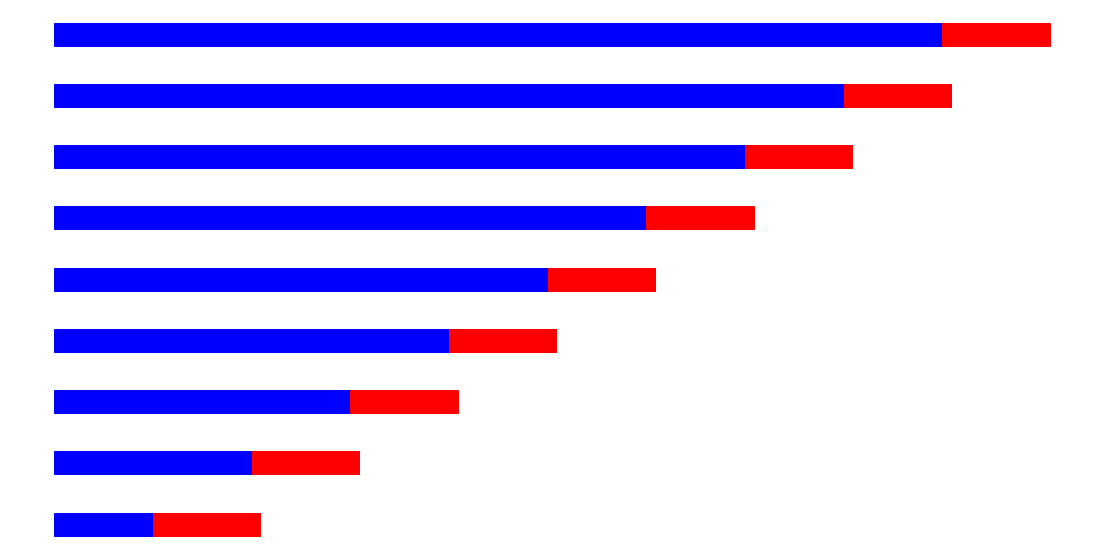

In [8]:
# Walk-forward (expanding window)

def walk_forward_tscv(X, y, n_splits=7):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []
    
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        unique, counts_train = np.unique(y_train, return_counts=True)
        train_distribution = dict(zip(unique, counts_train))
        
        unique, counts_test = np.unique(y_test, return_counts=True)
        test_distribution = dict(zip(unique, counts_test))
        
        splits.append((train_index, test_index))
        
        print(f"Split {i+1}:")
        print(f"  Training set class distribution: {train_distribution}")
        print(f"  Testing set class distribution: {test_distribution}")
        print("-" * 50)
    
    visualize_tscv_splits(X, splits)

def visualize_tscv_splits(X, splits):
    fig, ax = plt.subplots(figsize=(14, 7))
    for i, (train_index, test_index) in enumerate(splits):
        ax.scatter(train_index, np.repeat(i + 1, len(train_index)), c='blue', label='Training data' if i == 0 else "", marker='_', s=60, linewidth=17)
        ax.scatter(test_index, np.repeat(i + 1, len(test_index)), c='red', label='Testing data' if i == 0 else "", marker='_', s=60, linewidth=17)

    #ax.legend()
    ax.set_yticks(np.arange(1, len(splits) + 1))
    ax.set_yticklabels([f'Split {i+1}' for i in range(len(splits))])
    #ax.set_xlabel('Index of data point')
    #ax.set_ylabel('CV split')
    #ax.set_title('Training and Testing Splits for Expanding Window TSCV')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.savefig(f'')
    plt.show()

#predictor_columns = reduced_df
predictor_columns = df_all
X = predictor_columns.values
y = df['Fault_Status'].values
walk_forward_tscv(X, y, n_splits=9)

Split 1:
  Training set class distribution: {0: 620, 1: 520}
  Testing set class distribution: {1: 150}
--------------------------------------------------
Split 2:
  Training set class distribution: {0: 620, 1: 520}
  Testing set class distribution: {0: 148, 1: 2}
--------------------------------------------------
Split 3:
  Training set class distribution: {0: 689, 1: 451}
  Testing set class distribution: {0: 22, 1: 128}
--------------------------------------------------
Split 4:
  Training set class distribution: {0: 630, 1: 510}
  Testing set class distribution: {0: 28, 1: 122}
--------------------------------------------------
Split 5:
  Training set class distribution: {0: 529, 1: 611}
  Testing set class distribution: {0: 150}
--------------------------------------------------
Split 6:
  Training set class distribution: {0: 538, 1: 602}
  Testing set class distribution: {0: 32, 1: 118}
--------------------------------------------------
Split 7:
  Training set class distribution:

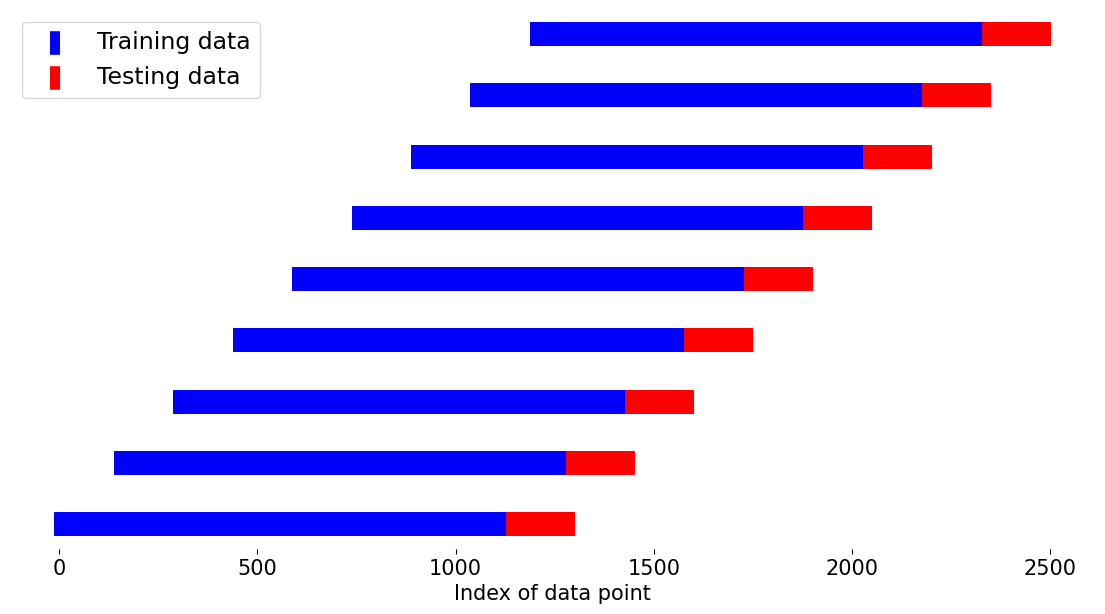

In [9]:
# overlapping window (sliding window)

def sliding_window_tscv(X, y, n_splits=7, test_size=150):

    total_size = len(X)
    train_size = total_size - (n_splits * test_size)  # Calculate initial training set size
    splits = []
    
    for i in range(n_splits):
        start_train = i * test_size
        end_train = start_train + train_size
        start_test = end_train
        end_test = start_test + test_size
        
        # Ensure we do not go out of bounds
        if end_test > total_size:
            break
        
        train_index = np.arange(start_train, end_train)
        test_index = np.arange(start_test, end_test)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        unique, counts_train = np.unique(y_train, return_counts=True)
        train_distribution = dict(zip(unique, counts_train))
        
        unique, counts_test = np.unique(y_test, return_counts=True)
        test_distribution = dict(zip(unique, counts_test))
        
        splits.append((train_index, test_index))
        
        print(f"Split {i+1}:")
        print(f"  Training set class distribution: {train_distribution}")
        print(f"  Testing set class distribution: {test_distribution}")
        print("-" * 50)
    
    visualize_tscv_splits(X, splits)

def visualize_tscv_splits(X, splits):
    fig, ax = plt.subplots(figsize=(14, 7))
    for i, (train_index, test_index) in enumerate(splits):
        ax.scatter(train_index, np.repeat(i + 1, len(train_index)), c='blue', label='Training data' if i == 0 else "", marker='_', s=60, linewidth=17)
        ax.scatter(test_index, np.repeat(i + 1, len(test_index)), c='red', label='Testing data' if i == 0 else "", marker='_', s=60, linewidth=17)

    ax.legend()
    ax.set_yticks(np.arange(1, len(splits) + 1))
    ax.set_yticklabels([f'Split {i+1}' for i in range(len(splits))])
    ax.set_xlabel('Index of data point')
    #ax.set_ylabel('CV split')
    #ax.set_title('Training and Testing Splits for Sliding Window TSCV')
    #ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.savefig(f'')
    plt.show()

#predictor_columns = reduced_df
predictor_columns = df_all
X = predictor_columns.values
y = df['Fault_Status'].values
sliding_window_tscv(X, y, n_splits=9, test_size=150)

Training Set Shapes:
X_train: (2241, 330), y_train: (2241,)
Testing Set Shapes:
X_test: (249, 330), y_test: (250,)

Class Distribution:
Training set:
(array([0, 1]), array([1069, 1172]))
Testing set:
(array([0]), array([250]))


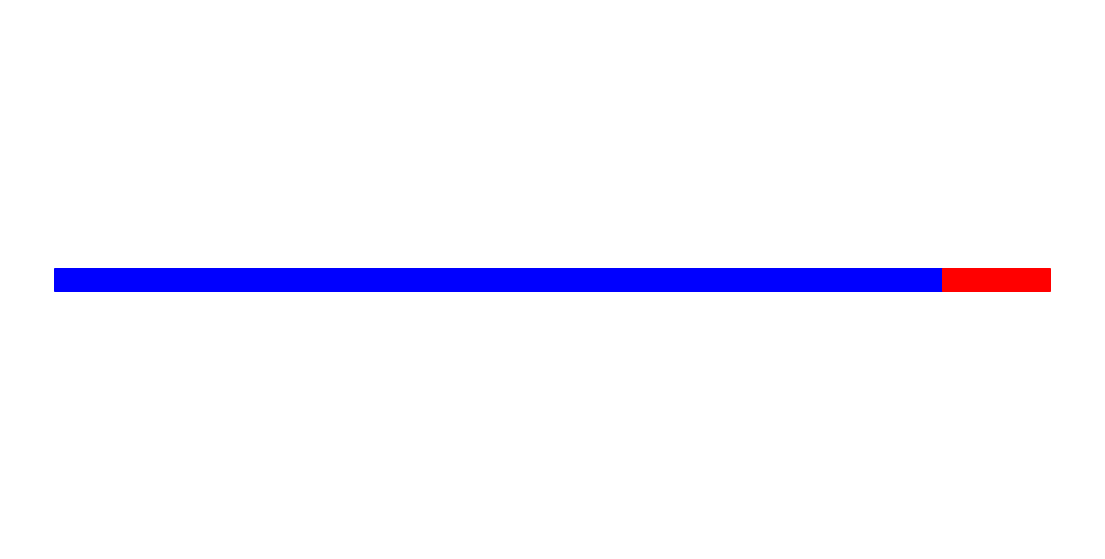

In [11]:
# Perform Holdout Split
train_size = 0.9  # 70% for training
split_index = int(len(X) * train_size)

# Sequential train-test split
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on training set and transform
X_test = scaler.transform(X_test)        # Transform test set

# Reshape if needed for models like CNN/RNN
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Verify the split
print("Training Set Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print("Testing Set Shapes:")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Class distribution check
print("\nClass Distribution:")
print(f"Training set:\n{np.unique(y_train, return_counts=True)}")
print(f"Testing set:\n{np.unique(y_test, return_counts=True)}")

def visualize_holdout_split(X, train_index, test_index):

    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot the training and testing indices
    ax.scatter(train_index, np.ones(len(train_index)), c='blue', label='Training data', marker='_', s=60, linewidth=17)
    ax.scatter(test_index, np.ones(len(test_index)), c='red', label='Testing data', marker='_', s=60, linewidth=17)
    
    # Customize plot appearance
    #ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Save the figure as a PDF
    plt.savefig('')
    plt.show()

# Prepare the holdout split indices
train_index = np.arange(0, split_index)
test_index = np.arange(split_index, len(X))

# Call the visualization function
visualize_holdout_split(X, train_index, test_index)